In [1]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)
    
from src.predictionModule.LoadupSamples import LoadupSamples
from src.predictionModule.FilterSamples import FilterSamples
from src.predictionModule.MachineModels import MachineModels

import numpy as np
import pandas as pd
import polars as pl
import datetime
import scipy

import logging
formatted_date = datetime.datetime.now().strftime("%d%b%y_%H%M").lower()

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter(fmt="%(asctime)s - %(message)s")
handler.setFormatter(formatter)
if not logger.hasHandlers():
    logger.addHandler(handler)
else:
    logger.handlers[:] = [handler]

#Output File handler
formatted_str = f"notebook-stomp-{formatted_date}"
file_handler = logging.FileHandler(f"{formatted_str}.log", mode="w")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Usage
logger.setLevel(logging.INFO)
logger.info("This will print to the notebook's output cell")

2025-09-03 15:56:04,358 - This will print to the notebook's output cell


In [ ]:
params = {
    "idxAfterPrediction": 5,
    'timesteps': 90,
    'target_option': 'last',
    "LoadupSamples_time_scaling_stretch": True,
    "LoadupSamples_time_inc_factor": 61,

    "FilterSamples_q_up": 0.985,
    
    "FilterSamples_cat_over20": True,
    "FilterSamples_cat_posOneYearReturn": False,
    "FilterSamples_cat_posFiveYearReturn": False,
}

In [30]:
timegroup = "group_regOHLCV_over5years"
treegroup = "group_debug"

eval_date = datetime.date(year=2023, month=2, day=13)
evaldates = [eval_date - datetime.timedelta(days=i) for i in range(1, 6)]
start_train_date = datetime.date(year=2021, month=6, day=1)
split_Date = datetime.date(year=2023, month=1, day=1)
ls = LoadupSamples(
    train_start_date=start_train_date,
    test_dates=evaldates,
    treegroup=treegroup,
    timegroup=timegroup,
    params=params,
)
ls.load_samples(main_path = "../src/featureAlchemy/bin/")
ls.split_dataset(
    start_date=start_train_date,
    last_train_date=split_Date,
    last_test_date=eval_date
)
fs_pre = FilterSamples(
    Xtree_train = ls.train_Xtree, 
    ytree_train = ls.train_ytree, 
    treenames   = ls.featureTreeNames,
    Xtree_test  = ls.test_Xtree,  
    ytree_test  = ls.test_ytree,
    meta_train  = ls.meta_pl_train, 
    meta_test   = ls.meta_pl_test, 
    params      = params
)
mask_train_pre, mask_test_pre = fs_pre.categorical_masks()
ls.apply_masks(mask_train_pre, mask_test_pre)

2025-09-03 16:39:14,391 - Test date 2023-02-12 not found in the database. Omitting.
2025-09-03 16:39:14,400 - Test date 2023-02-11 not found in the database. Omitting.


In [31]:
Xtree_train = ls.train_Xtree
ytree_train = ls.train_ytree
Xtree_test  = ls.test_Xtree
ytree_test  = ls.test_ytree

Xtime_train = ls.train_Xtime
ytime_train = ls.train_ytime
Xtime_test  = ls.test_Xtime
ytime_test  = ls.test_ytime

treenames   = ls.featureTreeNames
timenames   = ls.featureTimeNames
meta_train  = ls.meta_pl_train
meta_test   = ls.meta_pl_test

,time_window,feature_set,n_features,k,best_cluster,best_score,labels,features_idx,scores
0,35,f1,1,6,2,0.003827,"[1, 5, 1, 3, 1, 0, 5, 1, 1, 3, 1, 1, 3, 1, 3, ...",[1],"[-0.0008945061573080171, 0.000528875045916255,..."
1,10,f1,1,3,2,0.002987,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, ...",[1],"[-0.0012412439615712145, -0.004010796519080095..."
2,35,all,2,6,1,0.002406,"[4, 0, 3, 4, 4, 2, 0, 5, 4, 4, 4, 4, 4, 4, 5, ...","[0, 1]","[-0.006476143092995601, 0.0024060424680381054,..."
3,35,f0,1,6,1,0.002123,"[2, 0, 1, 2, 3, 3, 0, 0, 2, 2, 4, 2, 4, 2, 0, ...",[0],"[-0.00103133920194598, 0.0021231551008757954, ..."
4,10,f1,1,6,4,0.001888,"[0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 2, ...",[1],"[-0.0015227962414534613, -0.001600393241092512..."
5,10,f0,1,6,1,0.001838,"[2, 0, 4, 2, 5, 2, 1, 0, 2, 0, 0, 2, 0, 2, 5, ...",[0],"[-0.0005703645794260526, 0.0018384135395497214..."
6,35,f0,1,3,1,0.001126,"[2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, ...",[0],"[-0.0018150743539770975, 0.0011264160006474455..."
7,35,f1,1,3,2,0.000832,"[1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...",[1],"[-0.0045886431747222955, -0.000733003177896374..."
8,10,all,2,6,1,0.000799,"[4, 5, 2, 4, 0, 4, 4, 4, 4, 4, 0, 4, 0, 4, 5, ...","[0, 1]","[-0.001270108193702657, 0.0007989366042941981,..."
9,35,all,2,3,1,0.000098,"[1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, ...","[0, 1]","[-0.0008466636304539366, 9.780337020592889e-05..."


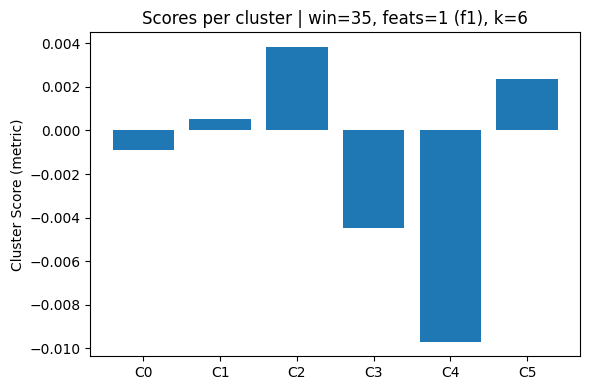

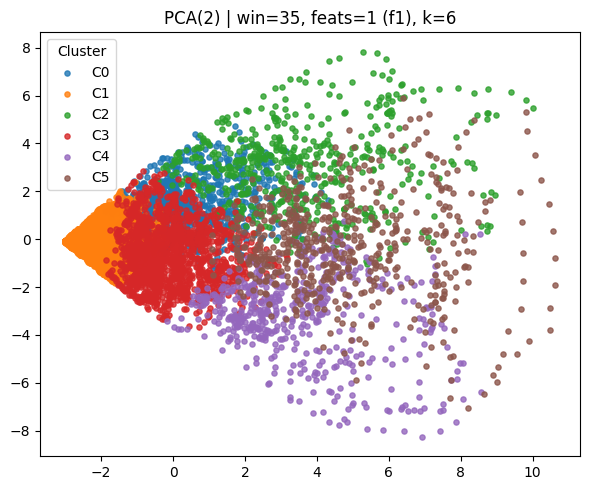

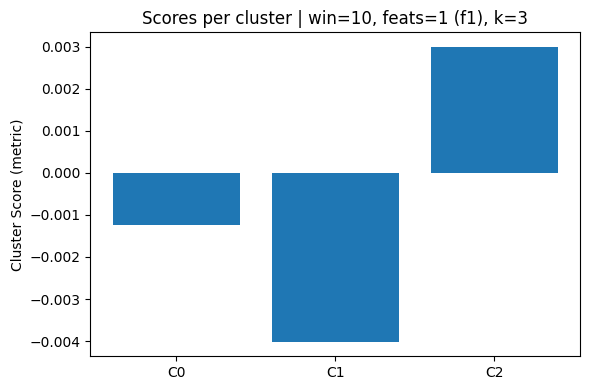

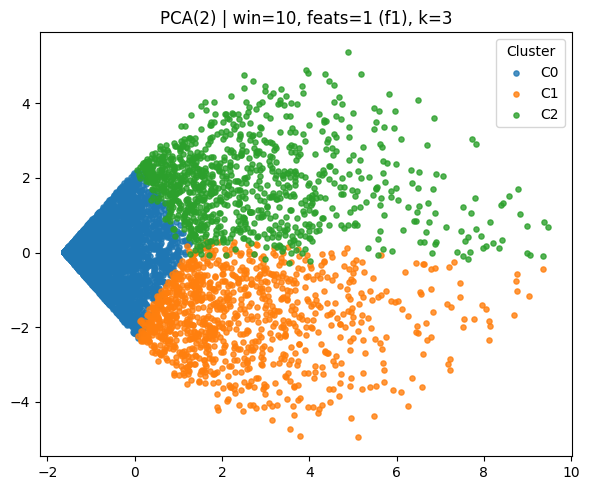

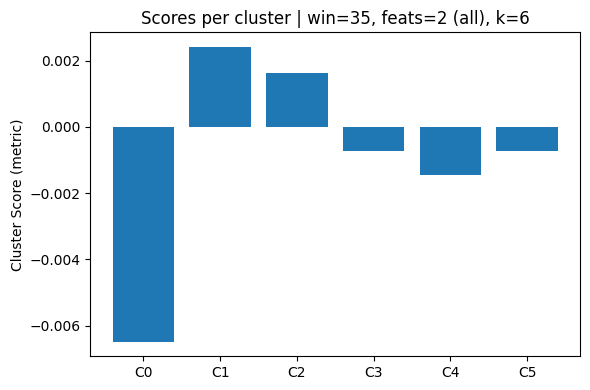

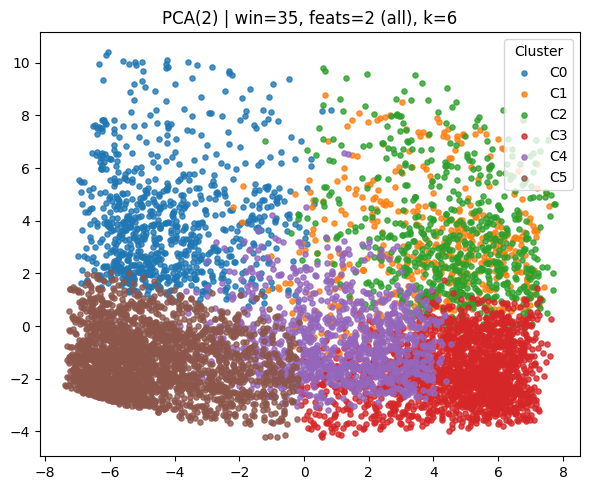

In [32]:
# --- MOTIF/CLUSTER SWEEP: best geometric-mean cluster over time/feature/k choices ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from itertools import product

# ************ Inputs expected in your session ************
# Xtime_train: (nS, nT, nF)
# ytime_train: (nS, nT) or (nS,)   (we'll use last timestep if 2D)
# Xtime_test, ytime_test: optional; not required here
# timenames: list[str] of length nT (optional; for labels)
# *******************************************************

X = Xtime_train
y = ytree_train
nS, nT, nF = X.shape

# --- target vector (use last timestep if 2D) ---
if y.ndim == 2:
    y_vec = y[:, -1]
else:
    y_vec = y

def geometric_mean_safe(arr):
    arr = np.asarray(arr, dtype=float)
    minv = np.min(arr)
    shift = 0.0
    # Ensure positivity for log; small epsilon if zeros/negatives present
    if minv <= 0:
        shift = -minv + 1e-9
    return float(np.exp(np.mean(np.log(arr + shift))))

def metric(arr):
    """Custom cluster score function. Change formula as needed."""
    gm = geometric_mean_safe(arr)
    return gm - 1

def make_design(X, t_win, feat_idx):
    Xw = X[:, -t_win:, feat_idx]
    return Xw.reshape(Xw.shape[0], -1)

# Search space
time_windows = sorted({w for w in [10, 40, nT] if 1 <= w <= nT})
feature_sets = [('all', np.arange(nF))] + [(f'f{j}', np.array([j])) for j in range(min(5, nF))]
cluster_ks = [3, 6]

results = []
for t_win, (f_name, f_idx), k in product(time_windows, feature_sets, cluster_ks):
    Xd = make_design(X, t_win, f_idx)
    Xs = StandardScaler().fit_transform(Xd)
    if k >= len(Xs):
        continue
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(Xs)

    scores = []
    for c in range(k):
        idx = np.where(labels == c)[0]
        if len(idx) > 0:
            scores.append(metric(y_vec[idx]))
        else:
            scores.append(-np.inf)

    best_c = int(np.argmax(scores))
    best_score = float(scores[best_c])

    results.append({
        'time_window': t_win,
        'feature_set': f_name,
        'n_features': len(f_idx),
        'k': k,
        'best_cluster': best_c,
        'best_score': best_score,
        'labels': labels,
        'features_idx': f_idx,
        'scores': scores,
    })

res_df = pd.DataFrame(results).sort_values(['best_score'], ascending=False).reset_index(drop=True)
display(res_df.head(10))

# --- Plot top results ---
topN = min(3, len(res_df))
for r in range(topN):
    row = res_df.iloc[r]
    t_win, f_idx, k = int(row.time_window), row.features_idx, int(row.k)
    labels, scores = row.labels, row.scores

    # Bar plot of cluster scores
    plt.figure(figsize=(6,4))
    plt.bar([f'C{c}' for c in range(k)], scores)
    plt.title(f'Scores per cluster | win={t_win}, feats={len(f_idx)} ({row.feature_set}), k={k}')
    plt.ylabel('Cluster Score (metric)')
    plt.tight_layout()
    plt.show()

    # PCA scatter
    Xd = make_design(X, t_win, f_idx)
    Xs = StandardScaler().fit_transform(Xd)
    XY = PCA(n_components=2, random_state=42).fit_transform(Xs)

    plt.figure(figsize=(6,5))
    for c in range(k):
        idx = np.where(labels == c)[0]
        plt.scatter(XY[idx,0], XY[idx,1], label=f'C{c}', s=14, alpha=0.8)
    plt.legend(title='Cluster')
    plt.title(f'PCA(2) | win={t_win}, feats={len(f_idx)} ({row.feature_set}), k={k}')
    plt.tight_layout()
    plt.show()

Using best config from search: win=35, feats=1 (f1), k=6


,cluster,train_score,test_score,delta(test-train),train_count,test_count
0,C0,-0.000895,0.021579,0.022474,894,53
1,C1,0.000529,0.018937,0.018408,3193,199
2,C2,0.003827,0.034834,0.031008,550,33
3,C3,-0.004482,0.015453,0.019935,1552,181
4,C4,-0.009687,0.009223,0.018911,527,18
5,C5,0.002346,0.022240,0.019895,556,20


Train-best cluster: C2 | train=0.00382672, test=0.0348342, Δ=0.0310075 (rel 810.29%), counts: train=550, test=33


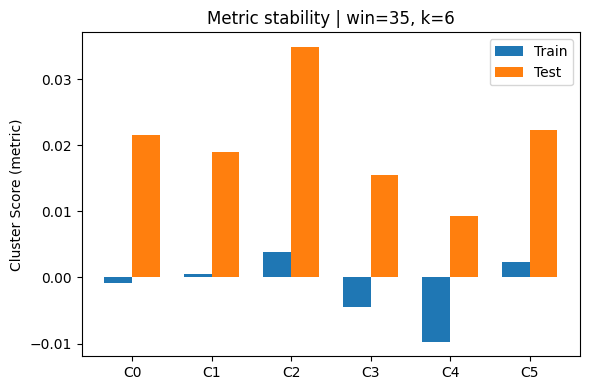

In [33]:
# --- Train→Test transfer: compare cluster metric stability ---

ytr_vec = (ytree_train)
yte_vec = (ytree_test)

# Pull best config from previous search; fallback if missing
if 'res_df' in globals() and len(res_df) > 0:
    cfg = res_df.iloc[0]
    t_win = int(cfg.time_window)
    f_idx = cfg.features_idx
    k = int(cfg.k)
    print(f"Using best config from search: win={t_win}, feats={len(f_idx)} ({cfg.feature_set}), k={k}")
else:
    raise NotImplementedError("res_df not found; please run the search step first.")

# Build design matrices (same window/features)
Xd_tr = make_design(Xtime_train, t_win, f_idx)
Xd_te = make_design(Xtime_test,  t_win, f_idx)

# Scale on train, apply to test
scaler = StandardScaler().fit(Xd_tr)
Xs_tr = scaler.transform(Xd_tr)
Xs_te = scaler.transform(Xd_te)

# Fit KMeans on train and predict test labels
km = KMeans(n_clusters=k, n_init='auto', random_state=42).fit(Xs_tr)
lab_tr = km.labels_
lab_te = km.predict(Xs_te)

# Compute metric per cluster on train & test
train_scores, test_scores, ntr, nte = [], [], [], []
for c in range(k):
    idx_tr = np.where(lab_tr == c)[0]
    idx_te = np.where(lab_te == c)[0]
    ntr.append(len(idx_tr)); nte.append(len(idx_te))
    tr_s = metric(ytr_vec[idx_tr]) if len(idx_tr) else np.nan
    te_s = metric(yte_vec[idx_te]) if len(idx_te) else np.nan
    train_scores.append(tr_s); test_scores.append(te_s)

# Identify best cluster on TRAIN and compare its score on TEST
best_c = int(np.nanargmax(train_scores))
best_train = train_scores[best_c]
best_test  = test_scores[best_c]
delta = best_test - best_train
reld = delta / (abs(best_train) + 1e-12)

# Summary table
summary = pd.DataFrame({
    'cluster': [f'C{c}' for c in range(k)],
    'train_score': train_scores,
    'test_score':  test_scores,
    'delta(test-train)': np.array(test_scores) - np.array(train_scores),
    'train_count': ntr,
    'test_count':  nte,
})
display(summary)

print(f"Train-best cluster: C{best_c} | train={best_train:.6g}, test={best_test:.6g}, "
      f"Δ={delta:.6g} (rel {reld:.2%}), counts: train={ntr[best_c]}, test={nte[best_c]}")

# Plot train vs test scores per cluster
plt.figure(figsize=(6,4))
x = np.arange(k)
w = 0.35
plt.bar(x - w/2, train_scores, width=w, label='Train')
plt.bar(x + w/2, test_scores,  width=w, label='Test')
plt.xticks(x, [f'C{c}' for c in range(k)])
plt.ylabel('Cluster Score (metric)')
plt.title(f'Metric stability | win={t_win}, k={k}')
plt.legend()
plt.tight_layout()
plt.show()
